In [62]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
import numpy as np
import time
import matplotlib.pyplot as plt
import math

In [2]:
img=256
img_size=[img,img]

numOfClasses=26
batchSize=64
Epochs=30

In [3]:
model= tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(50,(2,2), input_shape=(img,img,3)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(70,(3,3)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(70,(3,3)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(numOfClasses, activation="softmax")

])

C:\Users\zapat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 255, 255, 50)   │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 255, 255, 50)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 50)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 127, 127, 50)   │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 70)   │        31,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 125, 125, 70)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 70)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 70)     │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 70)     │        44,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 60, 60, 70)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 70)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 30, 70)     │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 63000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    16,128,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,212,088 (61.84 MB)

 Trainable params: 16,211,708 (61.84 MB)

 Non-trainable params: 380 (1.48 KB)

None


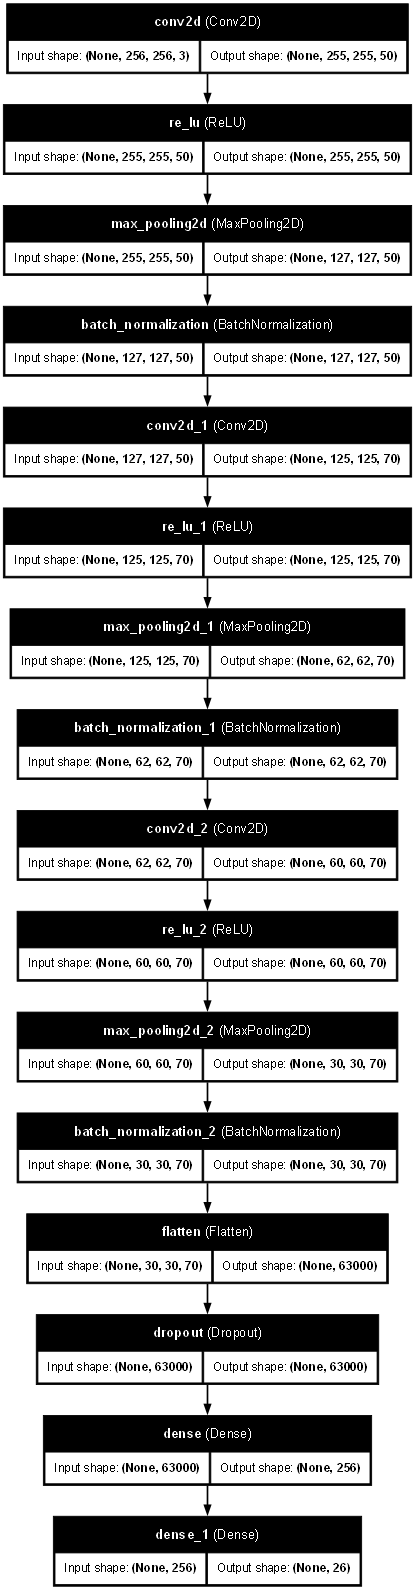

In [9]:
tf.keras.utils.plot_model(model,to_file="arquitectura.png", show_shapes=True, show_layer_names=True, dpi=60)

In [5]:
optimizer = Adam(learning_rate=0.001,
                beta_1=0.9,
                beta_2=0.999,
                decay=0.001)
loss_function = BinaryCrossentropy()
model.compile(loss=loss_function, optimizer="adam", metrics=["accuracy"])

C:\Users\zapat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [10]:
trainFolder=r"train"
testFolder=r"validation"

In [11]:
train_datagen=ImageDataGenerator(rescale=1. / 255)
training_set=train_datagen.flow_from_directory(trainFolder,
                                               shuffle=True,
                                               target_size=img_size,
                                               batch_size=batchSize,
                                               class_mode="categorical"
                                               )

Found 8616 images belonging to 26 classes.


In [12]:
test_datagen=ImageDataGenerator(rescale=1. / 255)
test_set=test_datagen.flow_from_directory(testFolder,
                                            shuffle=False,
                                            target_size=img_size,
                                            batch_size=batchSize,
                                            class_mode="categorical",
                                            #color_mode="grayscale"
                                            )

Found 1024 images belonging to 26 classes.


In [9]:
stepsPerEpochs = int(np.ceil(training_set.samples / batchSize))
validationSteps = int(np.ceil(test_set.samples / batchSize))


# Guardar ubicación del modelo

In [12]:
model_file="train_model/modelo3.keras"
bestModel=ModelCheckpoint(model_file, monitor="val_accuracy", save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [13]:
def create_class_weight(generator, mu=0.8):
    labels_dict = generator.classes
    total = len(generator.classes)
    unique_labels = np.unique(generator.classes)
    class_weight = dict()

    for label in unique_labels:
        class_count = np.sum(generator.classes == label)
        score = math.log(mu * total / float(class_count))
        class_weight[label] = score if score > 1.0 else 1.0

    return class_weight

class_weights_u = create_class_weight(training_set)
print(class_weights_u)

{0: 4.184272317364491, 1: 4.233062481533923, 2: 1.0, 3: 1.5721038879655638, 4: 3.679177368307486, 5: 4.33842299719175, 6: 3.9706982170664324, 7: 3.6734466935985006, 8: 3.8077947461295794, 9: 3.8546260458136783, 10: 2.9831607453195876, 11: 2.8695251075366492, 12: 3.5964856524623725, 13: 3.7630588522881876, 14: 4.165403833060108, 15: 3.8753880372621077, 16: 4.050740924739968, 17: 3.236113846642314, 18: 4.001950760570537, 19: 3.882405609920754, 20: 4.679349584162343, 21: 4.11973379622692, 22: 4.08464247641565, 23: 2.930149729353084, 24: 4.443783512849576, 25: 2.258981455511914}


In [14]:
history=model.fit(
    training_set,
    validation_data=test_set,
    epochs=Epochs,
    callbacks=[bestModel, early_stopping],
    class_weight=class_weights_u
)

Epoch 1/30


C:\Users\zapat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


135/135 ━━━━━━━━━━━━━━━━━━━━ 454s 3s/step - accuracy: 0.8597 - loss: 7.0019 - val_accuracy: 0.0742 - val_loss: 41.1578
Epoch 2/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 448s 3s/step - accuracy: 0.9668 - loss: 0.7705 - val_accuracy: 0.0352 - val_loss: 67.7988
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 0.9738 - loss: 0.3805 - val_accuracy: 0.1553 - val_loss: 26.1914
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 0.9762 - loss: 0.4424 - val_accuracy: 0.5596 - val_loss: 10.4655
Epoch 5/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 448s 3s/step - accuracy: 0.9636 - loss: 1.0377 - val_accuracy: 0.8408 - val_loss: 7.5604
Epoch 6/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 448s 3s/step - accuracy: 0.9673 - loss: 1.6995 - val_accuracy: 0.8799 - val_loss: 1.1128
Epoch 7/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 0.9779 - loss: 0.4983 - val_accuracy: 0.9648 - val_loss: 0.5874
Epoch 8/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - accuracy: 0.9834 - loss: 0.2683 - val_accuracy: 0

model save at epoch 8: accuracy: 0.9992 - loss: 0.0203 - val_accuracy: 0.9814 - val_loss: 0.2501

In [15]:
valResults=model.evaluate(test_set)
print(valResults)
print(model.metrics_names)

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 906ms/step - accuracy: 0.9814 - loss: 0.1589
[0.46693551540374756, 0.9599609375]
['loss', 'compile_metrics']


display results on charts

In [16]:
#hi=history
acc=history.history["accuracy"]
val_ac=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]

In [17]:
actualEpochs=range(len(acc))
print(f"actual epochs: {str(actualEpochs)}")

actual epochs: range(0, 15)


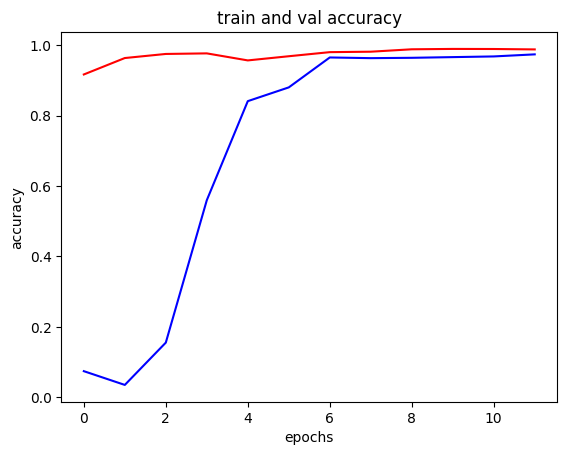

In [18]:
plt.plot(actualEpochs[:12], acc[:12], "r", label="train_acc")
plt.plot(actualEpochs[:12], val_ac[:12], "b", label="val_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("train and val accuracy")
plt.show()


In [14]:
modelo_f=load_model(r"train_model\modelo3.keras")
classes = list(test_set.class_indices.keys())

In [17]:
def precision_graph(report_dict, classes):
    plt.figure(figsize=(12, 10))
    plt.bar(classes, [report_dict[c]["precision"] for c in classes], color="blue", alpha=0.5, label="Precision")
    plt.title("Métricas de precisión")
    plt.xlabel("Familias de malware")
    plt.ylabel("Score")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [18]:
def recall_graph(report_dict, classes):
    plt.figure(figsize=(12, 10))
    plt.bar(classes, [report_dict[c]["recall"] for c in classes], color="green", alpha=0.5, label="Recall")
    plt.title("Métricas de recall")
    plt.xlabel("Familias de malware")
    plt.ylabel("Score")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [19]:
def fscore_graph(report_dict, classes):
    plt.figure(figsize=(12, 10))
    plt.bar(classes, [report_dict[c]["f1-score"] for c in classes], color="orange", alpha=0.5, label="F1-score")
    plt.title("Métricas de f1-score")
    plt.xlabel("Familias de malware")
    plt.ylabel("Score")
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.show()

C:\Users\zapat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 920ms/step
Reporte:
                precision    recall  f1-score   support

     Adialer.C       1.00      1.00      1.00        16
     Agent.FYI       0.94      1.00      0.97        16
     Allaple.A       1.00      1.00      1.00       296
     Allaple.L       1.00      1.00      1.00       160
 Alueron.gen!J       1.00      1.00      1.00        24
     Autorun.K       0.00      0.00      0.00        16
       C2LOP.P       0.82      0.88      0.85        16
   C2LOP.gen!g       0.96      0.96      0.96        24
Dialplatform.B       1.00      1.00      1.00        24
     Dontovo.A       1.00      1.00      1.00        16
      Fakerean       1.00      1.00      1.00        32
 Instantaccess       1.00      1.00      1.00        40
    Lolyda.AA1       1.00      1.00      1.00        24
    Lolyda.AA2       1.00      1.00      1.00        24
    Lolyda.AA3       1.00      1.00      1.00        16
     Lolyda.AT       1.00      0.94      0.97       

C:\Users\zapat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zapat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zapat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classificati

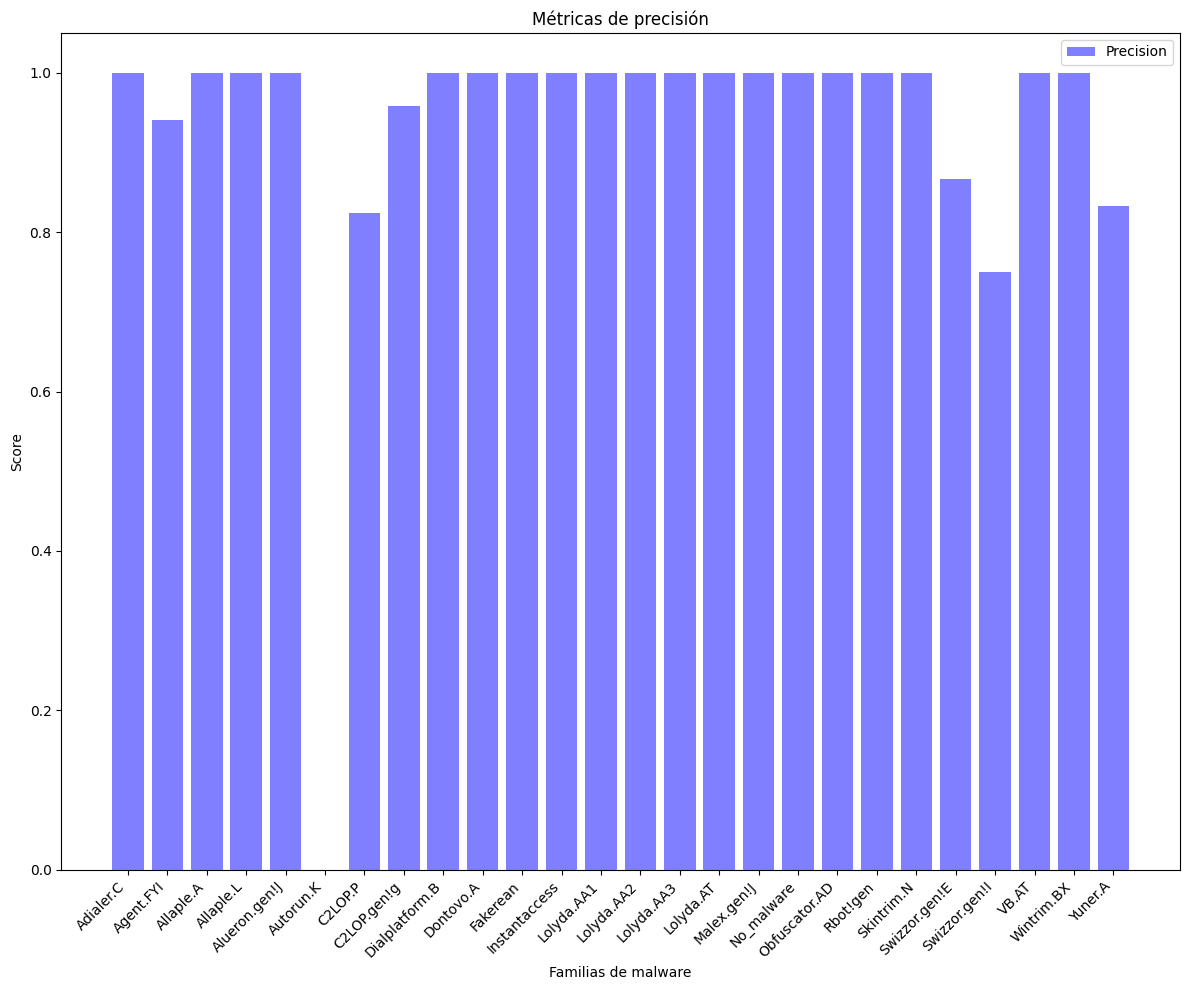

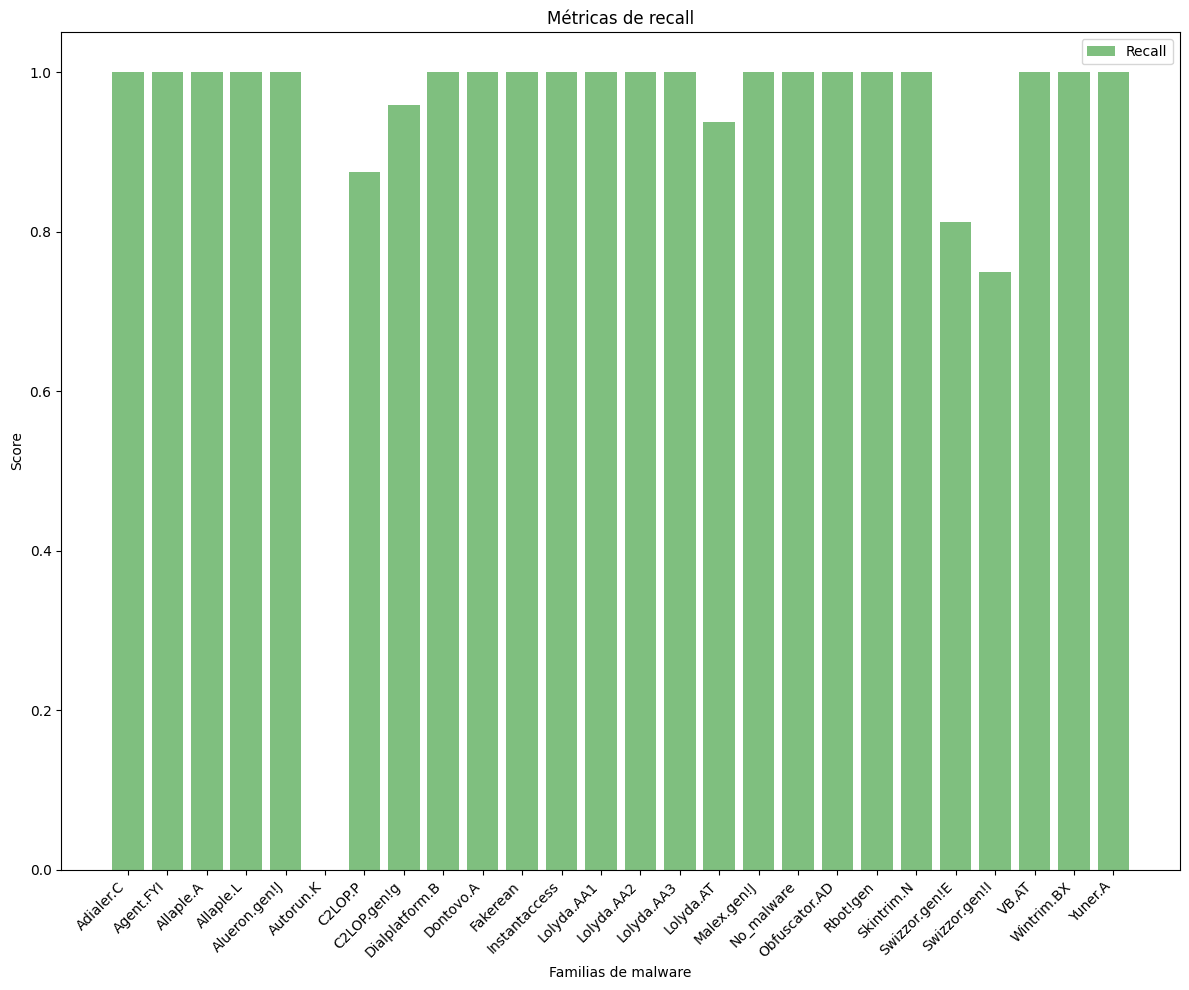

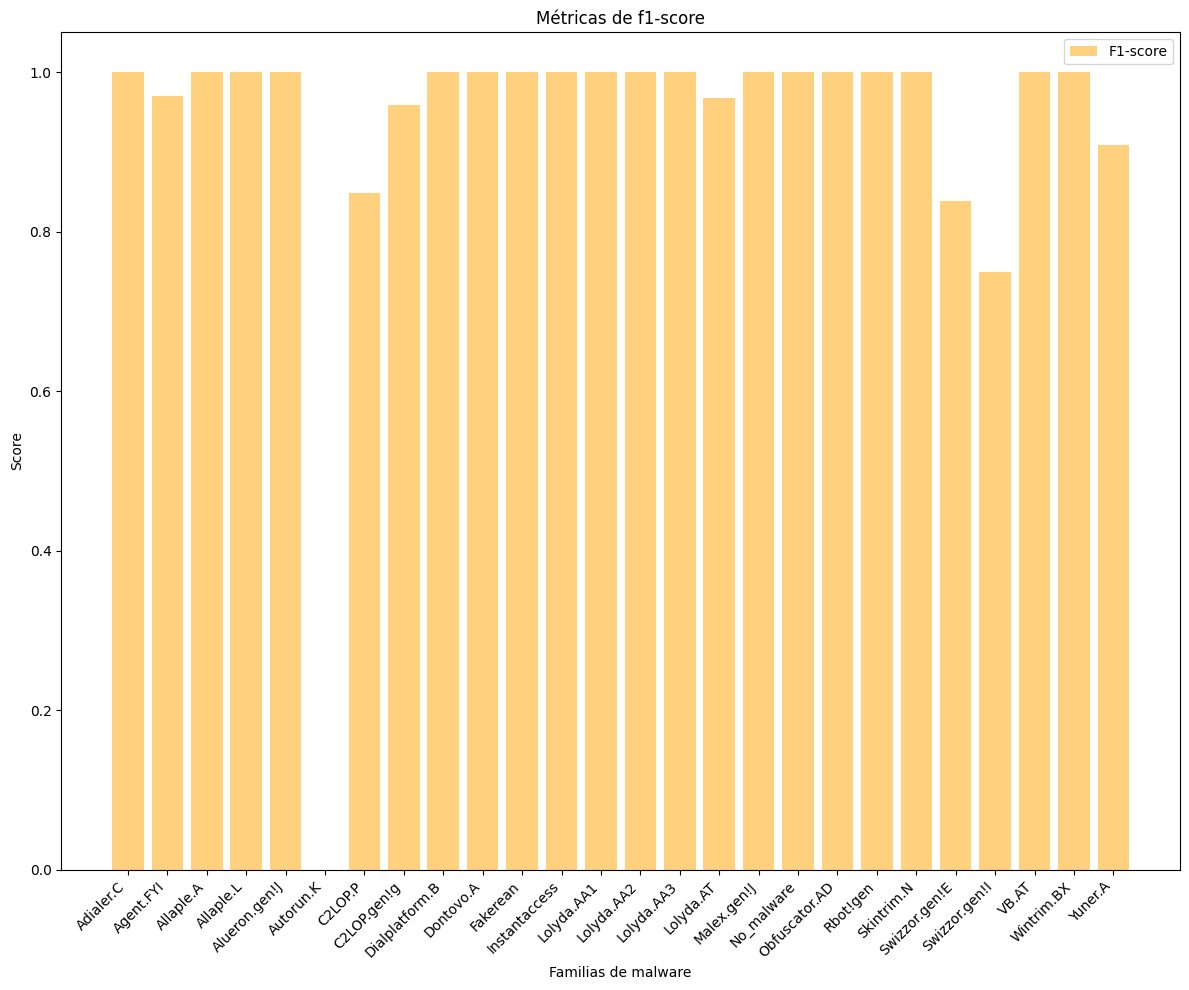

In [20]:
def calculate_and_plot_f1_score(test_data, classes, modelo_f):
    test_labels = test_data.labels
    
    # Predecir utilizando el modelo cargado
    predictions = modelo_f.predict(test_data)
    
    # Obtener el reporte de clasificación que incluye el F1-score, recall, precision y el support
    report_str = classification_report(test_labels, np.argmax(predictions, axis=1), target_names=classes)

    # Imprimir el reporte de clasificación en texto
    print("Reporte:")
    print(report_str)

    # Convertir el reporte de clasificación a un diccionario
    report_dict = classification_report(test_labels, np.argmax(predictions, axis=1), target_names=classes, output_dict=True)

    # Calcular el F1-score promedio
    f1_score = report_dict['macro avg']['f1-score']
    print(f"El F1-score es: {f1_score}")

    precision_graph(report_dict, classes)
    recall_graph(report_dict, classes)
    fscore_graph(report_dict, classes)
    

calculate_and_plot_f1_score(test_set, classes, modelo_f)

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 901ms/step


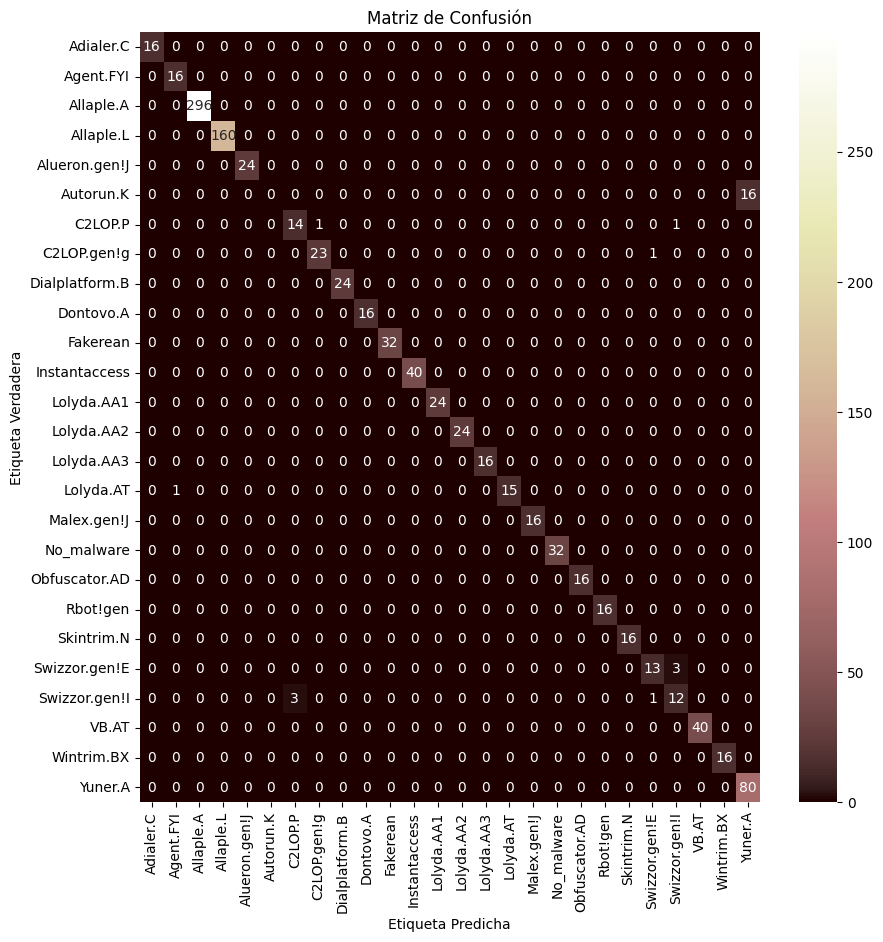

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def matriz_confusion(modelo_f, test_set):
    # Obtener las predicciones del modelo en el conjunto de prueba
    predictions = modelo_f.predict(test_set)

    # Convertir las predicciones de las probabilidades a clases
    predicted_classes = np.argmax(predictions, axis=1)

    # Obtener las etiquetas verdaderas del conjunto de prueba
    true_classes = test_set.classes

    # Obtener la lista de nombres de las clases
    class_names = list(test_set.class_indices.keys())

    # Calcular la matriz de confusión
    cm = confusion_matrix(true_classes, predicted_classes)


    # Crear un mapa de calor utilizando seaborn
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='pink', xticklabels=class_names, yticklabels=class_names, facecolor='#800080')
    plt.xlabel('Etiqueta Predicha')
    plt.ylabel('Etiqueta Verdadera')
    plt.title('Matriz de Confusión')
    plt.show()
    
matriz_confusion(modelo_f,test_set)


# ROC

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 940ms/step


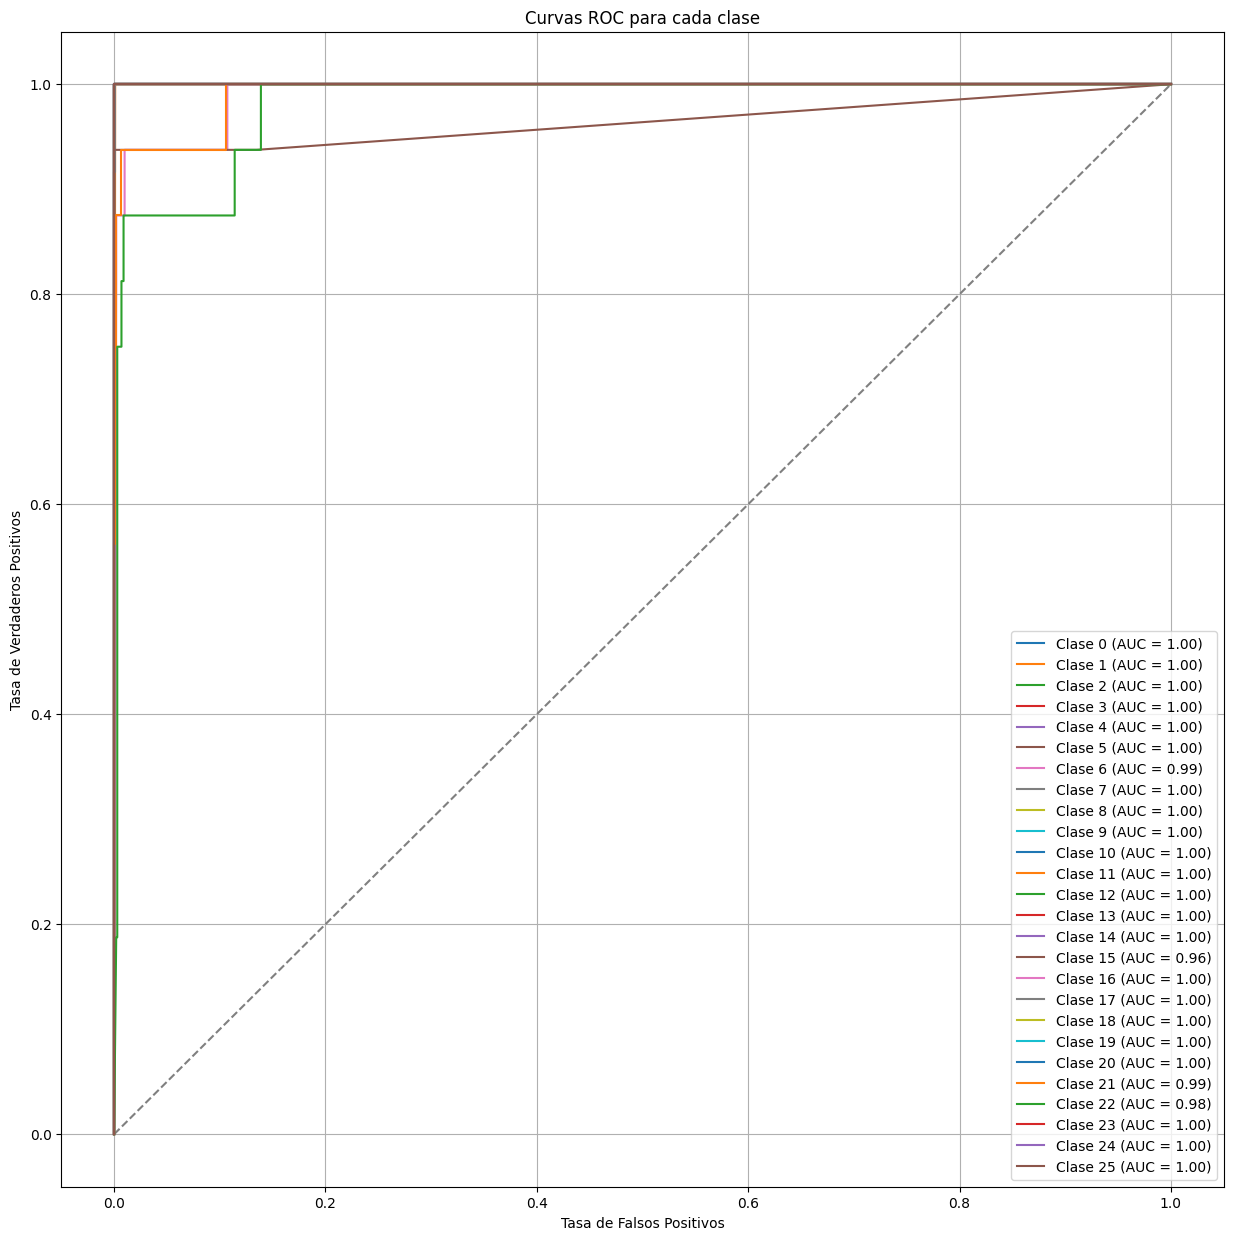

In [97]:
def curva_roc(modelo_f, test_set):
    y_pred_proba = modelo_f.predict(test_set)  # Obtener probabilidades predichas
    y_true = test_set.classes
    n_classes = y_pred_proba.shape[1]  # Número de clases
    
    plt.figure(figsize=(15, 15))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal
    
    for i in range(n_classes):
        # Obtener probabilidades para la clase i
        prob_class_i = y_pred_proba[:, i]
        
        # Crear las etiquetas binarias para la clase i
        y_true_i = np.array([1 if y == i else 0 for y in y_true])
        
        # Calcular la curva ROC para la clase i
        fpr, tpr, _ = roc_curve(y_true_i, prob_class_i)
        
        # Calcular el AUC para la clase i
        auc_score = auc(fpr, tpr)
        
        # Graficar la curva ROC para la clase i
        plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {auc_score:.2f})')
    
    plt.xlabel("Tasa de Falsos Positivos")
    plt.ylabel("Tasa de Verdaderos Positivos")
    plt.title("Curvas ROC para cada clase")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


curva_roc(modelo_f, test_set)